# Exploratory data analysis of photovoltaic dataset

This notebook is part of a project to predict the production of solar energy of a photovoltaic system on top of a house. In this notebook, we will consider the exploratory data analysis of the photovoltaic dataset that was obtained from the interface of the machine.

## Table of content

## [1. Import libraries](#section1) 
## [2. Load all the data into one dataframe](#section2) 
## [3. Visualize](#section3) 
## [4. Compute total energy production for each day](#section4) 
## [5. Visualize seasonal energy production](#section5)
## [6. Check for missing data](#section6)

<a id='section1'></a> 
## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.integrate import simps, quad
sns.set()

<a id='section2'></a> 
## 2. Load all the data into one dataframe

In [2]:
# Folder where the data is located
DATAFOLDER = '../01.Original_data/photovoltaic/'

# files in that folder
files = [f for f in os.listdir(DATAFOLDER) if f.endswith('.csv')] # take only csv files
len(files)

1740

We have 1740 csv files with photovoltaic data. Let us import them.

In [3]:
df = pd.DataFrame()

for f in files:
    df_temp = pd.read_csv(f'{DATAFOLDER}/{f}')
    df_temp.columns = ['timestamp', 'production'] # timestamp, production in W
    # conver the timestamp column
    df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'], format="%d.%m.%Y %H:%M")
    df_temp = df_temp.set_index('timestamp', drop=True)
    df = df.append(df_temp)
#     break


Let's save it because this took a while.

In [4]:
df = df.sort_index()
df.to_csv('../02.Prepared_data/photovoltaic/raw_data.csv', index=True)
df.head()

,production
timestamp,
2017-10-12,0.0
2017-10-12,0.0
2017-10-12,0.0
2017-10-12,0.0
2017-10-12,0.0


In [5]:
# import
df = pd.read_csv('../02.Prepared_data/photovoltaic/raw_data.csv', index_col=0, parse_dates=True)
df['day'] = df.index.date
df['time'] = df.index.time

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 167040 entries, 2017-10-12 00:00:00 to 2019-06-27 23:45:00
Data columns (total 3 columns):
production    167040 non-null float64
day           167040 non-null object
time          167040 non-null object
dtypes: float64(1), object(2)
memory usage: 10.1+ MB


In [7]:
df.describe()

,production
count,167040.000000
mean,1195.422325
std,1905.557358
min,0.000000
25%,0.000000
50%,0.000000
75%,1856.000000
max,6963.666500


In [8]:
df.head()

,production,day,time
timestamp,,,
2017-10-12,0.0,2017-10-12,00:00:00
2017-10-12,0.0,2017-10-12,00:00:00
2017-10-12,0.0,2017-10-12,00:00:00
2017-10-12,0.0,2017-10-12,00:00:00
2017-10-12,0.0,2017-10-12,00:00:00


In [9]:
df.tail()

,production,day,time
timestamp,,,
2019-06-27 22:45:00,0.0,2019-06-27,22:45:00
2019-06-27 23:00:00,0.0,2019-06-27,23:00:00
2019-06-27 23:15:00,0.0,2019-06-27,23:15:00
2019-06-27 23:30:00,0.0,2019-06-27,23:30:00
2019-06-27 23:45:00,0.0,2019-06-27,23:45:00


We see that we have data from October 2017 until end of June 2019 and only the production data of the photovoltaic system. The resolution of the data is in 15-minte intervals.

Let us see how many days we have and if the overall number of intervals does check out.

In [10]:
n_days = len(df['day'].unique())
print(f'We have {n_days} days in the dataset.')
df_agg = df.groupby('day').agg('count').loc[:, 'production']
df_agg.value_counts()

We have 624 days in the dataset.


96       618
192        2
19392      1
53184      1
34464      1
288        1
Name: production, dtype: int64

Interesting, so typically there are 96 entries ($24*4$ for the total of the 15-minute intervals in one day) per day, but there are 6 days where this criteria is not met. Let's see which these are!

In [11]:
m = df_agg == 96# mask
df_agg[~m]

day
2017-10-12    19392
2018-03-24      288
2018-03-25    34464
2019-03-30      192
2019-03-31    53184
2019-06-26      192
Name: production, dtype: int64

In [12]:
df.loc['2019-03-30'].index

DatetimeIndex(['2019-03-30 00:00:00', '2019-03-30 00:00:00',
               '2019-03-30 00:15:00', '2019-03-30 00:15:00',
               '2019-03-30 00:30:00', '2019-03-30 00:30:00',
               '2019-03-30 00:45:00', '2019-03-30 00:45:00',
               '2019-03-30 01:00:00', '2019-03-30 01:00:00',
               ...
               '2019-03-30 22:45:00', '2019-03-30 22:45:00',
               '2019-03-30 23:00:00', '2019-03-30 23:00:00',
               '2019-03-30 23:15:00', '2019-03-30 23:15:00',
               '2019-03-30 23:30:00', '2019-03-30 23:30:00',
               '2019-03-30 23:45:00', '2019-03-30 23:45:00'],
              dtype='datetime64[ns]', name='timestamp', length=192, freq=None)

It is clear now that these values are from duplicates, generated by the mining process. We just have to drop them.

In [13]:
df = df.drop_duplicates(keep='first')

In [14]:
n_days = len(df['day'].unique())
print(f'We have {n_days} days in the dataset.')
df.groupby('day').agg('count').loc[:, 'production'].value_counts()

We have 624 days in the dataset.


96    624
Name: production, dtype: int64

Perfect, let's now visualize the data.

<a id='section3'> </a>
## 3. Visualize 

/Users/hkromer/anaconda3/envs/solarAnalytics/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


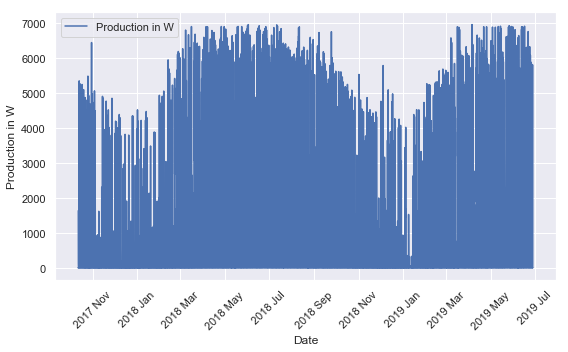

In [15]:
# %matplotlib widget
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,5))

X = df.index.values

# apparent 
col = 'production'
Y = df[col].values
plt.plot(X, Y, label='Production in W')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Production in W')
plt.legend()
plt.tight_layout()
plt.show()

Here we have the hourly production, which is not what we are looking for, let us look at the total daily production in units of kWh by integrating the curve for each day.

<a id='section4'> </a>
## 4. Compute total energy production for each day

in kWh!

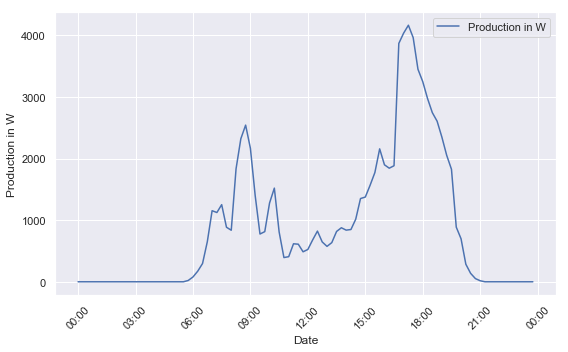

In [16]:
# %matplotlib widget
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,5))

X = df.loc['2018-07-03'].index.values

# apparent 
col = 'production'
Y = df.loc['2018-07-03', col]
plt.plot(X, Y, label='Production in W')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Production in W')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# compute the kWh for one given day
def compute_kwh(df):
    """
    Calculate the kWh for a given production output for one day in a dataframe, df. Returns the kWh
    """
    df['seconds_after_midnight'] = df.reset_index().index * 15 * 60
    x = df['seconds_after_midnight'].values
    y = df['production'].values
    y_int = simps(y=y, x=x) / (3.6e6) # in units of kWh
    return y_int
# groupby day
# apply function to compute kWh
df_int = pd.DataFrame(df.groupby('day').apply(lambda x: compute_kwh(x)))
df_int.columns = ['energy']

Let's also visualize that.

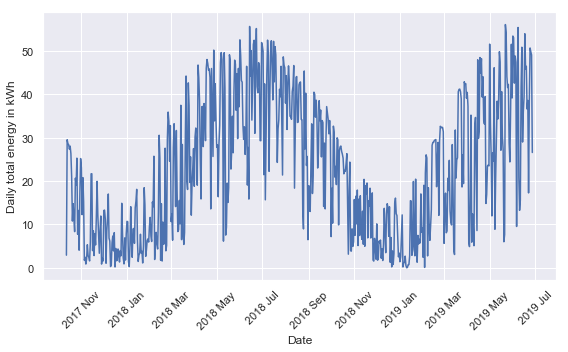

In [18]:
# %matplotlib widget
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,5))

X = df_int.index.values

Y = df_int['energy'].values
plt.plot(X, Y)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Daily total energy in kWh')
plt.tight_layout()
plt.show()

Very good! Let's look at these values.

In [19]:
df_int.describe()

,energy
count,624.000000
mean,22.660990
std,15.654720
min,0.000000
25%,7.961104
50%,20.838417
75%,34.805437
max,56.130500


Interesting, we see that the mean of the production is 22.7 kWh for any day, with extremas of 0 and 56 kWh. Most of the data is between 0 and 20.8 kWh (50%). 

<a id='section5'></a>

## 5. Visualize seasonal energy production

Let us also consider the four seasons.

In the northern hemisphere, the four seasons are defined as (meteorologically):

* Spring: March until May
* Summer: June until August
* Fall: September until November
* Winter: December until February

In [20]:
df_int = df_int.set_index(pd.to_datetime(df_int.reset_index().loc[:, 'day']))

In [21]:
d_season = {
    'spring': [3, 4, 5],
    'summer': [6, 7, 8],
    'fall': [9, 10, 11],
    'winter': [12, 1, 2]
}
df_int['month'] = df_int.index.month

for k in d_season.keys():
    months = d_season[k]
    for month in months:
        df_int['month'] = df_int['month'].replace({month: k})

# to check, make it with some integers        
d_season_int = {
    'spring': 1,
    'summer': 2,
    'fall': 3,
    'winter': 0
}
s = df_int['month'].map(d_season_int)


df_int = df_int.rename(columns={'month': 'season'})

Let us check if we encoded the months correctly!

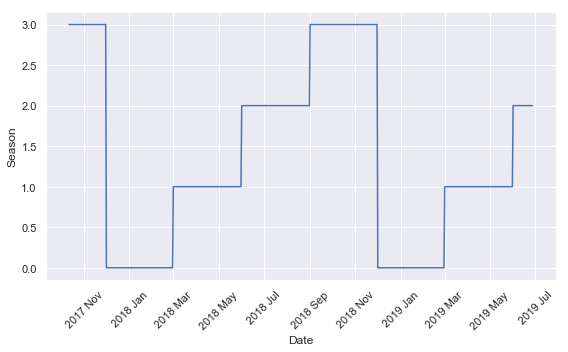

In [22]:
# %matplotlib widget
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,5))


plt.plot(s.index, s.values)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Season')
plt.tight_layout()
plt.show()

Seems fine (note that winter is 0, spring 1, summer 2, fall 3, as expected).


To get the seasonal production, let us group the data by the season and make a violinplot.

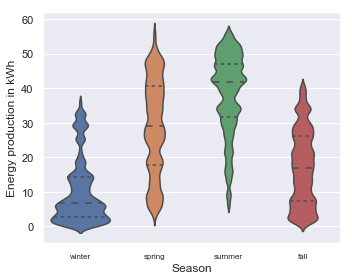

In [23]:
# %matplotlib widget
%matplotlib inline

fig, ax = plt.subplots(figsize=(5,4))
sns.violinplot(x="season", y="energy", data=df_int, ax=ax, inner='quartile', bw=0.1, order=[ "winter", "spring", "summer", "fall"])
plt.xticks(fontsize=8)
plt.ylabel('Energy production in kWh')
plt.xlabel('Season')
plt.tight_layout()
# plt.savefig('./seasonal_production.png', dpi=300)
plt.show()

What we see here is the distribution of daily energy production grouped by the different season. We identify the following key takeaways:

* The total productions are distributed to higher values for the summer and spring with medians of around 42 and 28 kWh, respectively, compared to around 8 kWh in the winter and 18 kWh in the fall.
* The shape of the distribution is more uniform in the spring and fall compared to the winter and summer. In the winter, the distribution is skewed towards lower values, and in the summer towards higher values.

<a id='section6'></a>

## 6. Check for missing data

In [24]:
# what missing values there are
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing,
                                'absolute_missing': df.isnull().sum()})
missing_value_df

,column_name,percent_missing,absolute_missing
production,production,0.0,0
day,day,0.0,0
time,time,0.0,0


In [28]:
# what missing values there are
percent_missing = df_int.isnull().sum() * 100 / len(df_int)
missing_value_df = pd.DataFrame({'column_name': df_int.columns,
                                 'percent_missing': percent_missing,
                                'absolute_missing': df_int.isnull().sum()})
missing_value_df

,column_name,percent_missing,absolute_missing
energy,energy,0.0,0
season,season,0.0,0


In [34]:
df_int.to_csv('../02.Prepared_data/photovoltaic/integrated_daily.csv', index=True)